In [18]:
# Celda 1: Importaciones y Configuración Inicial
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.auto import tqdm # Para barras de progreso en bucles largos
from typing import List, Dict, Tuple, Optional
import logging
# Configuración para que los plots se muestren en el notebook
%matplotlib inline
sns.set_style('whitegrid')

# Añadir la carpeta 'src' al path para importar config.py
module_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src')) # Asume que el notebook está en 'notebooks/'
if module_path not in sys.path:
    sys.path.append(module_path)

try:
    import config # Importa tu archivo de configuración centralizado
    config.setup_logging() # Configura el logging como lo tienes en tus scripts
    logging = config.logging # Usa la instancia de logging configurada
except ImportError:
    print("Error: No se pudo importar config.py. Asegúrate de que la ruta a 'src' sea correcta.")
    # Define aquí rutas manualmente SOLO SI la importación de config falla para pruebas rápidas
    # class ConfigMock: # Ejemplo de Mock, NO USAR PARA EL FLUJO FINAL
    #     CLUSTERING_DATA_DIR = "../data/clustering"
    #     PROCESSED_DATA_DIR = "../data/processed"
    #     EMBEDDINGS_REDUCED_OUTPUT_PATHS = {"discovery": os.path.join(CLUSTERING_DATA_DIR, "discovery_embeddings_reduced_umap_50d.npy")} # O el que vayas a usar
    #     EMBEDDINGS_IDS_OUTPUT_PATHS = {"discovery": os.path.join(CLUSTERING_DATA_DIR, "discovery_embeddings_ids.csv")}
    #     PREPROCESSED_OUTPUT_PATHS = {"discovery": os.path.join(PROCESSED_DATA_DIR, "discovery_preprocessed.csv")}
    #     COL_TWEET_ID = 'tweet_id'
    #     COL_PREPROCESSED_TEXT = 'text_preprocessed' # La columna con el texto ya limpio
    #     COL_TEXT = 'text' # Texto original si lo necesitas para comparar
    #     RANDOM_STATE = 42
    #     KMEANS_N_CLUSTERS_START = 5
    #     KMEANS_N_CLUSTERS_END = 20
    #     KMEANS_N_CLUSTERS_STEP = 1
    #     KMEANS_INIT = 'k-means++'
    #     KMEANS_N_INIT = 'auto' # o 10
    #     KMEANS_MAX_ITER = 300
    # config = ConfigMock()
    # import logging # Necesitarías configurar logging manualmente si config no se importa
    # logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


logging.info(f"Directorio para artefactos de clustering: {config.CLUSTERING_DATA_DIR}")
logging.info(f"Directorio para datos procesados: {config.PROCESSED_DATA_DIR}")

In [19]:
# Celda 2: Cargar Embeddings, IDs y Textos Preprocesados
# Nos enfocaremos en el conjunto de "discovery" para encontrar categorías

dataset_type = "discovery" 

# Usar las rutas de config.py para los embeddings reducidos (recomendado para clustering)
# o los completos si no hiciste reducción o quieres probar con ellos.
# Asegúrate que DIM_REDUCTION_SUFFIX en config.py esté correctamente definido.
embeddings_path = config.EMBEDDINGS_REDUCED_OUTPUT_PATHS.get(dataset_type)
if not config.FE_PERFORM_DIMENSIONALITY_REDUCTION or not os.path.exists(embeddings_path):
    logging.warning(f"Embeddings reducidos para '{dataset_type}' no encontrados o la reducción no se realizó. "
                    f"Intentando cargar embeddings completos desde: {config.EMBEDDINGS_FULL_OUTPUT_PATHS.get(dataset_type)}")
    embeddings_path = config.EMBEDDINGS_FULL_OUTPUT_PATHS.get(dataset_type)

ids_path = config.EMBEDDINGS_IDS_OUTPUT_PATHS.get(dataset_type)
texts_path = config.PREPROCESSED_OUTPUT_PATHS.get(dataset_type) # Usaremos el texto ya preprocesado por preprocessing.py

if not all([embeddings_path, ids_path, texts_path]):
    logging.error(f"Error: Rutas de entrada no definidas completamente en config.py para el conjunto '{dataset_type}'")
    # Detener aquí si las rutas no están.
    raise ValueError("Rutas de entrada no definidas en config.py")

logging.info(f"Cargando embeddings desde: {embeddings_path}")
logging.info(f"Cargando IDs desde: {ids_path}")
logging.info(f"Cargando textos desde: {texts_path}")

try:
    embeddings_to_cluster = np.load(embeddings_path)
    df_ids = pd.read_csv(ids_path)
    df_texts_data = pd.read_csv(texts_path)
    
    logging.info(f"Forma de los embeddings: {embeddings_to_cluster.shape}")
    logging.info(f"Número de IDs: {len(df_ids)}")
    logging.info(f"Columnas en df_texts_data: {df_texts_data.columns.tolist()}")

    if embeddings_to_cluster.shape[0] != len(df_ids):
        raise ValueError(f"Inconsistencia: {embeddings_to_cluster.shape[0]} embeddings vs {len(df_ids)} IDs.")
    
    # Unir los IDs con los textos para facilitar el análisis posterior
    # Asumimos que df_texts_data tiene config.COL_TWEET_ID y config.COL_PREPROCESSED_TEXT
    if config.COL_TWEET_ID not in df_texts_data.columns:
        raise ValueError(f"La columna ID '{config.COL_TWEET_ID}' no se encuentra en el archivo de textos: {texts_path}")
    if config.COL_PREPROCESSED_TEXT not in df_texts_data.columns:
        raise ValueError(f"La columna de texto preprocesado '{config.COL_PREPROCESSED_TEXT}' no se encuentra en: {texts_path}")

    # Seleccionar solo las columnas necesarias para el análisis y asegurarse de que el ID coincida
    df_analysis_base = pd.merge(
        df_ids, 
        df_texts_data[[config.COL_TWEET_ID, config.COL_TEXT, config.COL_PREPROCESSED_TEXT]], # Incluye original y preprocesado
        on=config.COL_TWEET_ID, 
        how='left'
    )
    # Asegurar que el orden de df_analysis_base coincida con el de los embeddings
    # Esto es crucial si df_ids no estaba originalmente en el mismo orden que los embeddings
    # Una forma es reindexar df_analysis_base usando el orden de df_ids (si df_ids está ordenado como los embeddings)
    # O, más seguro, si df_ids se guardó en el mismo orden que los embeddings:
    if not df_analysis_base[config.COL_TWEET_ID].equals(df_ids[config.COL_TWEET_ID]):
        logging.warning("El orden de IDs después del merge no coincide con el original de los embeddings. Reordenando...")
        # Esto asume que df_ids está en el orden correcto de los embeddings
        map_id_to_index = pd.Series(df_ids.index, index=df_ids[config.COL_TWEET_ID])
        df_analysis_base['sort_order'] = df_analysis_base[config.COL_TWEET_ID].map(map_id_to_index)
        df_analysis_base.sort_values('sort_order', inplace=True)
        df_analysis_base.drop('sort_order', axis=1, inplace=True)
        df_analysis_base.reset_index(drop=True, inplace=True)


    logging.info(f"DataFrame para análisis (df_analysis_base) creado con {len(df_analysis_base)} filas.")
    
except FileNotFoundError as e:
    logging.error(f"Error: No se encontró uno de los archivos de entrada: {e}")
    logging.error("Asegúrate de haber ejecutado feature_engineering.py para el conjunto de descubrimiento.")
except Exception as e:
    logging.error(f"Ocurrió un error al cargar los datos: {e}")
    raise e # Relanzar para detener la ejecución del notebook si la carga falla

Probando valores de k:   0%|          | 0/16 [00:00<?, ?it/s]

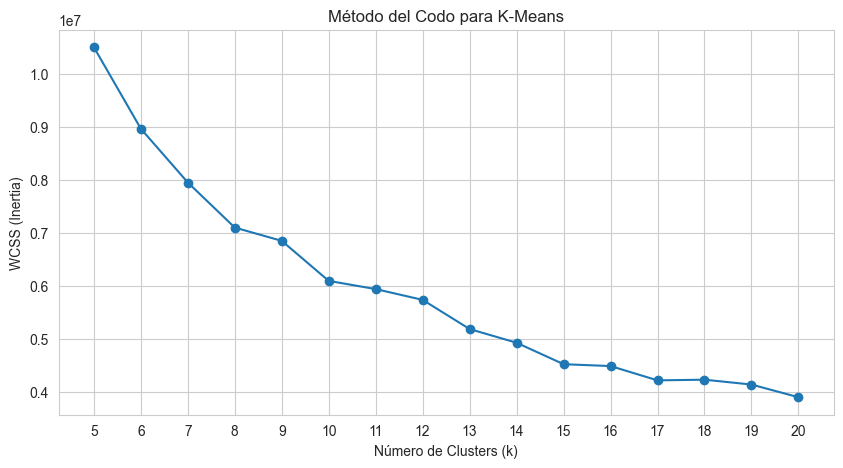

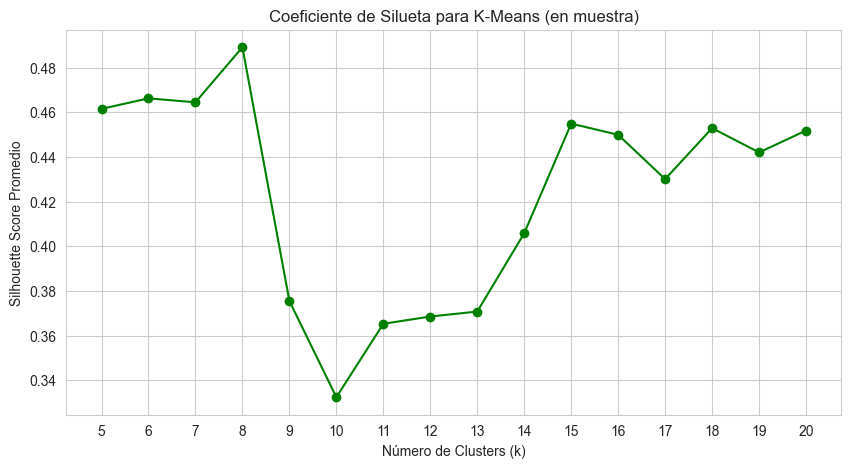

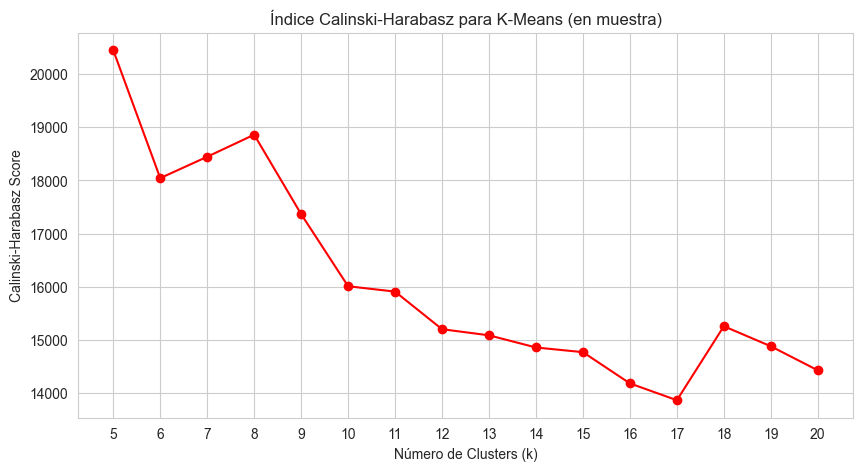

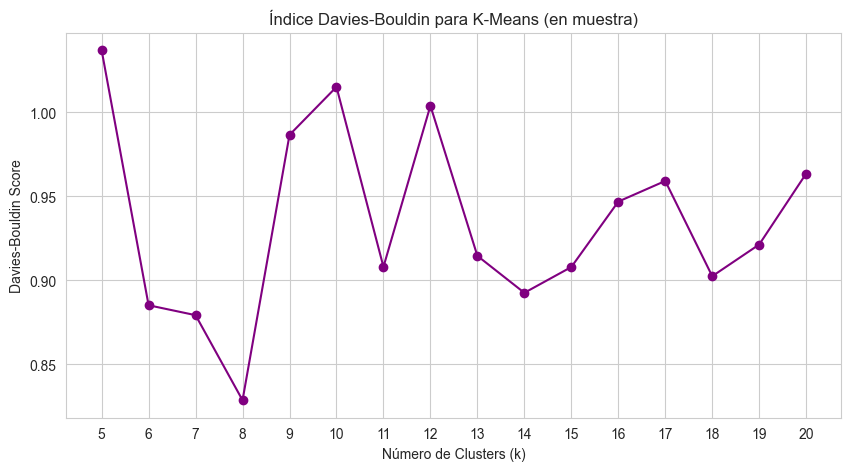

In [3]:
# Celda 3: Encontrar el Número Óptimo de Clusters (k) para K-Means

# Para datasets grandes, calcular Silhouette score en todo el dataset puede ser muy lento.
# Haremos el cálculo del codo en todo, y Silhouette en una muestra.
sample_size_for_metrics = min(50000, embeddings_to_cluster.shape[0])
if embeddings_to_cluster.shape[0] > sample_size_for_metrics:
    logging.info(f"Tomando una muestra de {sample_size_for_metrics} puntos para calcular Silhouette score.")
    np.random.seed(config.RANDOM_STATE) # Usa el RANDOM_STATE de config si está disponible
    sample_indices = np.random.choice(embeddings_to_cluster.shape[0], size=sample_size_for_metrics, replace=False)
    embeddings_sample_for_metrics = embeddings_to_cluster[sample_indices]
else:
    embeddings_sample_for_metrics = embeddings_to_cluster

# --- Define los parámetros de K-Means aquí en el notebook ---
KMEANS_N_CLUSTERS_START_NB = 5  # Define tu valor inicial de k para el notebook
KMEANS_N_CLUSTERS_END_NB = 20    # Define tu valor final de k para el notebook
KMEANS_N_CLUSTERS_STEP_NB = 1    # Define el paso para k
KMEANS_INIT_NB = 'k-means++'
KMEANS_N_INIT_NB = 'auto' 
KMEANS_MAX_ITER_NB = 300
RANDOM_STATE_NB = getattr(config, 'RANDOM_STATE', 42) # Intenta tomar de config, o usa un default
# -----------------------------------------------------------

k_range = range(KMEANS_N_CLUSTERS_START_NB, KMEANS_N_CLUSTERS_END_NB + 1, KMEANS_N_CLUSTERS_STEP_NB)

wcss = [] 
silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []

logging.info(f"Calculando métricas de K-Means para k en el rango: {list(k_range)}")
for k in tqdm(k_range, desc="Probando valores de k"):
    kmeans = KMeans(
        n_clusters=k,
        init=KMEANS_INIT_NB, # Usa la variable del notebook
        n_init=KMEANS_N_INIT_NB, # Usa la variable del notebook
        max_iter=KMEANS_MAX_ITER_NB, # Usa la variable del notebook
        random_state=RANDOM_STATE_NB # Usa la variable del notebook
    )
    # Método del Codo: se calcula sobre todos los datos (embeddings_to_cluster)
    kmeans.fit(embeddings_to_cluster)
    wcss.append(kmeans.inertia_)
    
    # Otras métricas: se calculan sobre la muestra para agilizar
    if len(embeddings_sample_for_metrics) >= k : # Necesitas al menos k muestras para k clusters
        cluster_labels_sample = kmeans.fit_predict(embeddings_sample_for_metrics) # Re-ajustar en la muestra para estas métricas
        if len(np.unique(cluster_labels_sample)) > 1: # Silhouette y otras necesitan al menos 2 clusters
            silhouette_scores.append(silhouette_score(embeddings_sample_for_metrics, cluster_labels_sample, metric='cosine')) # o 'euclidean'
            calinski_harabasz_scores.append(calinski_harabasz_score(embeddings_sample_for_metrics, cluster_labels_sample))
            davies_bouldin_scores.append(davies_bouldin_score(embeddings_sample_for_metrics, cluster_labels_sample))
        else:
            silhouette_scores.append(np.nan) # O algún valor que indique que no se pudo calcular
            calinski_harabasz_scores.append(np.nan)
            davies_bouldin_scores.append(np.nan)
    else:
        silhouette_scores.append(np.nan)
        calinski_harabasz_scores.append(np.nan)
        davies_bouldin_scores.append(np.nan)


# Graficar el Método del Codo
plt.figure(figsize=(10, 5))
plt.plot(list(k_range), wcss, marker='o')
plt.title('Método del Codo para K-Means')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(list(k_range))
plt.grid(True)
plt.show()

# Graficar Silhouette Score (si se calculó)
if any(not np.isnan(s) for s in silhouette_scores):
    plt.figure(figsize=(10, 5))
    plt.plot(list(k_range)[len(list(k_range)) - len(silhouette_scores):], silhouette_scores, marker='o', color='green')
    plt.title('Coeficiente de Silueta para K-Means (en muestra)')
    plt.xlabel('Número de Clusters (k)')
    plt.ylabel('Silhouette Score Promedio')
    plt.xticks(list(k_range)[len(list(k_range)) - len(silhouette_scores):])
    plt.grid(True)
    plt.show()
    logging.info(f"Valores de Silhouette Score: {silhouette_scores}")

# Graficar Calinski-Harabasz Index (si se calculó) - Más alto es mejor
if any(not np.isnan(s) for s in calinski_harabasz_scores):
    plt.figure(figsize=(10, 5))
    plt.plot(list(k_range)[len(list(k_range)) - len(calinski_harabasz_scores):], calinski_harabasz_scores, marker='o', color='red')
    plt.title('Índice Calinski-Harabasz para K-Means (en muestra)')
    plt.xlabel('Número de Clusters (k)')
    plt.ylabel('Calinski-Harabasz Score')
    plt.xticks(list(k_range)[len(list(k_range)) - len(calinski_harabasz_scores):])
    plt.grid(True)
    plt.show()
    logging.info(f"Valores de Calinski-Harabasz: {calinski_harabasz_scores}")

# Graficar Davies-Bouldin Index (si se calculó) - Más bajo es mejor
if any(not np.isnan(s) for s in davies_bouldin_scores):
    plt.figure(figsize=(10, 5))
    plt.plot(list(k_range)[len(list(k_range)) - len(davies_bouldin_scores):], davies_bouldin_scores, marker='o', color='purple')
    plt.title('Índice Davies-Bouldin para K-Means (en muestra)')
    plt.xlabel('Número de Clusters (k)')
    plt.ylabel('Davies-Bouldin Score')
    plt.xticks(list(k_range)[len(list(k_range)) - len(davies_bouldin_scores):])
    plt.grid(True)
    plt.show()
    logging.info(f"Valores de Davies-Bouldin: {davies_bouldin_scores}")

In [20]:
# Celda 4: Elegir un 'k' y Ejecutar K-Means Final sobre todo el Conjunto de Descubrimiento

# BASADO EN LAS GRÁFICAS ANTERIORES Y TU INTERPRETACIÓN, ELIGE UN VALOR PARA k_optimo
# Por ejemplo, si el codo está en k=10 y Silhouette es bueno ahí:
k_optimo = 8 # ¡¡¡DEBES AJUSTAR ESTE VALOR DESPUÉS DE VER LAS GRÁFICAS!!!

# --- Define los parámetros de K-Means aquí en el notebook ---
KMEANS_INIT_NB_FINAL = 'k-means++'  # Parámetro de inicialización para esta ejecución final
KMEANS_N_INIT_NB_FINAL = 'auto'     # Número de inicializaciones (o 10)
KMEANS_MAX_ITER_NB_FINAL = 300    # Máximo de iteraciones
RANDOM_STATE_NB_FINAL = getattr(config, 'RANDOM_STATE', 42) # Intenta tomar de config, o usa un default
# -----------------------------------------------------------

logging.info(f"Ejecutando K-Means final con k={k_optimo} sobre el conjunto completo de embeddings de descubrimiento...")
kmeans_final = KMeans(
    n_clusters=k_optimo,
    init=KMEANS_INIT_NB_FINAL,       # Usa la variable del notebook
    n_init=KMEANS_N_INIT_NB_FINAL,   # Usa la variable del notebook
    max_iter=KMEANS_MAX_ITER_NB_FINAL, # Usa la variable del notebook
    random_state=RANDOM_STATE_NB_FINAL # Usa la variable del notebook
)
cluster_labels_final = kmeans_final.fit_predict(embeddings_to_cluster)
# Añadir las etiquetas de cluster al DataFrame de análisis
df_analysis_base['cluster_id'] = cluster_labels_final

logging.info(f"\nDistribución de los {k_optimo} clusters finales:")
print(df_analysis_base['cluster_id'].value_counts().sort_index())

# Guardar el modelo K-Means entrenado (opcional pero recomendado)
# El nombre del archivo de salida del modelo debe reflejar el k_optimo
model_filename = f"discovery_kmeans_k{k_optimo}_model.joblib"
model_output_path = os.path.join(config.MODELS_DIR, model_filename) 
os.makedirs(config.MODELS_DIR, exist_ok=True) # Asegurar que la carpeta models exista
import joblib # Asegúrate de tenerlo importado
joblib.dump(kmeans_final, model_output_path)
logging.info(f"Modelo K-Means final (k={k_optimo}) guardado en: {model_output_path}")

# Guardar las asignaciones de clusters
assignments_filename = f"discovery_cluster_assignments_kmeans_k{k_optimo}.csv"
assignments_output_path = os.path.join(config.CLUSTERING_DATA_DIR, assignments_filename)
df_to_save_assignments = df_analysis_base[[config.COL_TWEET_ID, 'cluster_id']]
df_to_save_assignments.to_csv(assignments_output_path, index=False, encoding='utf-8')
logging.info(f"Asignaciones de clusters finales guardadas en: {assignments_output_path}")

cluster_id
0     68537
1      3239
2    121003
3    224921
4     12150
5    301795
6    159907
7    184938
Name: count, dtype: int64


c:\Users\nicot\anaconda3\envs\nequi_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\nicot\anaconda3\envs\nequi_env\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


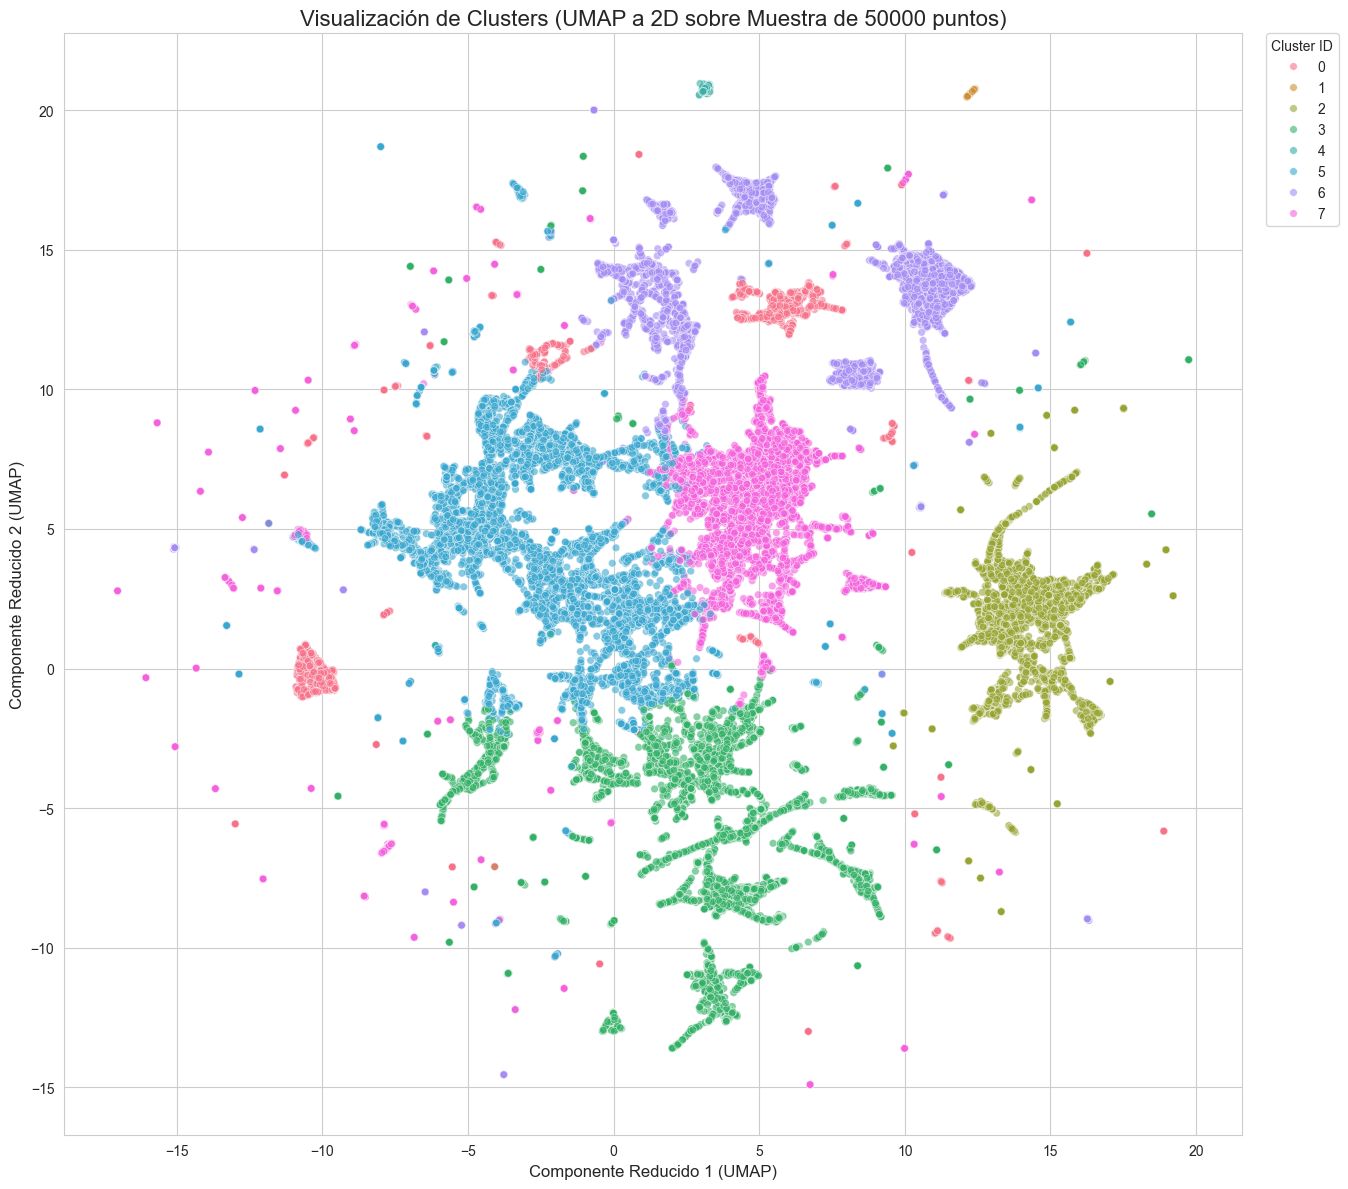

In [24]:
# Celda 4.5: Visualización de Clusters en 2D

# Asegúrate de que estas importaciones estén al inicio de tu notebook o en una celda anterior
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA # Añadido por si quieres probar PCA para visualización
# UMAP (manejar importación)
try:
    import umap.umap_ as Umap 
    UMAP_AVAILABLE_FOR_VIZ = True
except ImportError:
    try:
        import umap as Umap
    except ImportError:
        Umap = None
        UMAP_AVAILABLE_FOR_VIZ = False
        logging.warning("UMAP no está instalado o no se pudo importar. La visualización 2D con UMAP no estará disponible.")

# --- Verificación de Prerrequisitos ---
if 'df_analysis_base' not in locals() or df_analysis_base is None or 'cluster_id' not in df_analysis_base.columns:
    logging.error("El DataFrame 'df_analysis_base' con la columna 'cluster_id' no está definido.")
    logging.error("Asegúrate de haber ejecutado la celda de clustering (ej. Celda 4) y que 'cluster_id' haya sido añadido.")
    raise NameError("df_analysis_base o 'cluster_id' no están definidos. Ejecuta las celdas anteriores.")

if 'embeddings_to_cluster' not in locals() or embeddings_to_cluster is None:
    logging.error("Los embeddings 'embeddings_to_cluster' (los que usaste para el clustering) no están definidos o son None.")
    raise NameError("embeddings_to_cluster no está definido. Ejecuta las celdas anteriores.")

# --- Preparar Datos para Visualización ---
labels_for_plot_full = df_analysis_base['cluster_id'].values 
embeddings_for_clustering_viz = embeddings_to_cluster # Estos son los que usaste para clustering (ej. 50D)

# --- Tomar una MUESTRA para la reducción a 2D si el dataset es grande ---
sample_size_viz = 50000  # Ajusta este tamaño según la velocidad deseada vs. representatividad
embeddings_2d_for_plot = None
labels_for_viz_final_plot = None # Etiquetas correspondientes a la muestra que se graficará

if embeddings_for_clustering_viz.shape[0] > sample_size_viz:
    logging.info(f"Tomando una muestra aleatoria de {sample_size_viz} puntos para la visualización 2D.")
    np.random.seed(config.RANDOM_STATE) # Para reproducibilidad de la muestra
    sample_indices_viz = np.random.choice(
        embeddings_for_clustering_viz.shape[0], 
        size=sample_size_viz, 
        replace=False
    )
    embeddings_sample_for_viz_reduction = embeddings_for_clustering_viz[sample_indices_viz]
    labels_for_viz_final_plot = labels_for_plot_full[sample_indices_viz] # Etiquetas de la muestra
else:
    embeddings_sample_for_viz_reduction = embeddings_for_clustering_viz
    labels_for_viz_final_plot = labels_for_plot_full
logging.info(f"Dimensiones de los embeddings para reducción a 2D (muestra o completo): {embeddings_sample_for_viz_reduction.shape}")


# --- Reducción a 2D de la MUESTRA (si es necesario) ---
# Decide qué técnica usar para reducir esta MUESTRA a 2D para visualización
VIZ_REDUCTION_TECHNIQUE = "umap" # Puedes cambiar a "pca" para probar

if embeddings_sample_for_viz_reduction.shape[1] == 2:
    logging.info("Los embeddings de la muestra ya están en 2D, listos para graficar.")
    embeddings_2d_for_plot = embeddings_sample_for_viz_reduction
elif embeddings_sample_for_viz_reduction.shape[1] > 2: # Solo reducir si tiene más de 2 dimensiones
    if VIZ_REDUCTION_TECHNIQUE == "umap" and UMAP_AVAILABLE_FOR_VIZ:
        logging.info(f"Reduciendo muestra de {embeddings_sample_for_viz_reduction.shape[0]} puntos a 2D con UMAP...")
        umap_viz_params = {
            'n_neighbors': 15, 
            'n_components': 2, 
            'min_dist': 0.1,
            'metric': config.UMAP_METRIC if hasattr(config, 'UMAP_METRIC') else 'cosine',
            'random_state': config.RANDOM_STATE,
            'verbose': False # Puedes poner True para más detalle de UMAP
        }
        # Ajustar n_neighbors si la muestra es muy pequeña
        if embeddings_sample_for_viz_reduction.shape[0] <= umap_viz_params['n_neighbors']:
             umap_viz_params['n_neighbors'] = max(2, embeddings_sample_for_viz_reduction.shape[0] - 1)
             logging.warning(f"Ajustando n_neighbors de UMAP para visualización a {umap_viz_params['n_neighbors']}")
        
        if umap_viz_params['n_neighbors'] >= 2:
            try:
                embeddings_2d_for_plot = Umap.UMAP(**umap_viz_params).fit_transform(embeddings_sample_for_viz_reduction)
            except Exception as e:
                logging.error(f"Falló la reducción UMAP para visualización: {e}")
                embeddings_2d_for_plot = None
        else:
            logging.error("Muestra demasiado pequeña para UMAP-Viz.")
            embeddings_2d_for_plot = None

    elif VIZ_REDUCTION_TECHNIQUE == "pca":
        logging.info(f"Reduciendo muestra de {embeddings_sample_for_viz_reduction.shape[0]} puntos a 2D con PCA...")
        try:
            pca_viz = PCA(n_components=2, random_state=config.RANDOM_STATE)
            embeddings_2d_for_plot = pca_viz.fit_transform(embeddings_sample_for_viz_reduction)
        except Exception as e:
            logging.error(f"Falló la reducción PCA para visualización: {e}")
            embeddings_2d_for_plot = None
    else:
        logging.warning(f"Técnica de reducción para visualización '{VIZ_REDUCTION_TECHNIQUE}' no reconocida, UMAP no disponible, o no es PCA. No se graficará si no son 2D.")
        # Si los embeddings originales ya eran 3D y quieres mostrar los primeros 2 componentes:
        if embeddings_sample_for_viz_reduction.shape[1] == 3:
            logging.info("Usando los primeros 2 componentes de los embeddings 3D para visualización.")
            embeddings_2d_for_plot = embeddings_sample_for_viz_reduction[:, :2]


    if embeddings_2d_for_plot is not None:
        logging.info(f"Embeddings de muestra reducidos a 2D. Nueva forma: {embeddings_2d_for_plot.shape}")
else: # Menos de 2 dimensiones
    logging.error(f"Los embeddings de la muestra tienen menos de 2 dimensiones ({embeddings_sample_for_viz_reduction.shape[1]}). No se puede graficar.")


# --- Graficar los Clusters ---
if embeddings_2d_for_plot is not None and labels_for_viz_final_plot is not None:
    plt.figure(figsize=(16, 12)) # Aumentar tamaño de figura
    
    # Identificar puntos de ruido (-1) si existen (típico de HDBSCAN)
    # Si usas K-Means, no tendrás etiqueta -1, así que noise_points estará todo en False.
    noise_points_mask = (labels_for_viz_final_plot == -1)
    core_points_mask = ~noise_points_mask
    
    unique_labels_no_noise = np.unique(labels_for_viz_final_plot[core_points_mask])
    
    # Asegurar que la paleta tenga suficientes colores si hay clusters
    num_actual_clusters = len(unique_labels_no_noise)
    palette = sns.color_palette("husl", n_colors=max(1, num_actual_clusters)) # Evitar n_colors=0
    
    # Graficar puntos principales (no ruido)
    if np.any(core_points_mask): # Solo graficar si hay puntos core
        scatter_plot = sns.scatterplot(
            x=embeddings_2d_for_plot[core_points_mask, 0],
            y=embeddings_2d_for_plot[core_points_mask, 1],
            hue=labels_for_viz_final_plot[core_points_mask],
            palette=palette,
            s=30, # Tamaño del punto
            alpha=0.6,
            legend='full' 
        )
    else: # Si solo hay ruido (o ningún punto core), inicializar scatter_plot como None
        scatter_plot = None
        logging.info("No hay puntos 'core' (no ruido) para graficar.")

    # Graficar puntos de ruido (si hay)
    if np.any(noise_points_mask):
        sns.scatterplot(
            x=embeddings_2d_for_plot[noise_points_mask, 0],
            y=embeddings_2d_for_plot[noise_points_mask, 1],
            color='lightgray', # Color más sutil para el ruido
            marker='x',
            s=15,
            alpha=0.5,
            label='Ruido (-1)' # Etiqueta para la leyenda
        )
    
    # Manejo de Leyenda
    # Obtener handles y labels actuales del scatter_plot principal (si existe)
    handles, current_labels_in_legend = (scatter_plot.get_legend_handles_labels() if scatter_plot and scatter_plot.legend_ else ([], []))
    
    # Añadir el handle de ruido a la leyenda si hay puntos de ruido y no está ya
    if np.any(noise_points_mask) and 'Ruido (-1)' not in current_labels_in_legend:
        from matplotlib.lines import Line2D
        handles.append(Line2D([0], [0], marker='x', color='lightgray', linestyle='None', markersize=5, label='Ruido (-1)'))
        current_labels_in_legend.append('Ruido (-1)')
    elif not handles and np.any(noise_points_mask): # Si solo hubo ruido y no se creó scatter_plot
        from matplotlib.lines import Line2D
        handles = [Line2D([0], [0], marker='x', color='lightgray', linestyle='None', markersize=5, label='Ruido (-1)')]
        current_labels_in_legend = ['Ruido (-1)']

    if handles: # Solo mostrar leyenda si hay algo que mostrar
        plt.legend(handles, current_labels_in_legend, title='Cluster ID', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

    plt.title(f'Visualización de Clusters ({VIZ_REDUCTION_TECHNIQUE.upper()} a 2D sobre Muestra de {embeddings_sample_for_viz_reduction.shape[0]} puntos)', fontsize=16)
    plt.xlabel(f'Componente Reducido 1 ({VIZ_REDUCTION_TECHNIQUE.upper()})', fontsize=12)
    plt.ylabel(f'Componente Reducido 2 ({VIZ_REDUCTION_TECHNIQUE.upper()})', fontsize=12)
    plt.grid(True)
    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Ajustar para que quepa la leyenda
    plt.show()
else:
    logging.info("No se graficaron los clusters porque los embeddings 2D o las etiquetas de la muestra no están disponibles/generados.")

In [25]:
# Celda 5: Análisis Cualitativo de los Clusters y Asignación de Nombres de Categoría

# (Asegúrate que df_analysis_base y la columna 'cluster_id' estén definidos desde celdas anteriores)
# Ejemplo: Si tu columna de cluster se llama 'cluster_mcs150' y quieres usarla:
# chosen_cluster_column_for_analysis = 'cluster_mcs150' # O la que hayas elegido
# if chosen_cluster_column_for_analysis in df_analysis_base.columns and 'cluster_id' != chosen_cluster_column_for_analysis:
#     if 'cluster_id' in df_analysis_base.columns:
#          df_analysis_base.drop('cluster_id', axis=1, inplace=True, errors='ignore')
#     df_analysis_base.rename(columns={chosen_cluster_column_for_analysis: 'cluster_id'}, inplace=True)

if 'cluster_id' not in df_analysis_base.columns:
    logging.error("La columna 'cluster_id' no se encuentra en df_analysis_base. "
                  "Asegúrate de haber ejecutado el clustering y de que la columna de etiquetas exista con ese nombre o renómbrala.")
    # Considera detener el notebook o lanzar un error si esto es crítico
    # raise ValueError("Columna 'cluster_id' no encontrada en df_analysis_base.")
else:
    # Todo el código siguiente DEBE estar indentado bajo este 'else'
    logging.info(f"\n--- Iniciando Análisis Cualitativo para los clusters en la columna 'cluster_id' ---")

    # --- Funciones de Ayuda para el Análisis ---
    # Asegúrate de que estas importaciones estén al inicio de tu notebook o en una celda anterior
    # from typing import List, Optional 
    # from sklearn.feature_extraction.text import TfidfVectorizer
    # from tqdm.auto import tqdm
    # import pandas as pd
    # import numpy as np
    # import logging
    # import os
    # # import config # (Asumiendo que config ya está importado y sys.path configurado)

    def display_cluster_samples_with_valid_text(
        df: pd.DataFrame,
        cluster_id_col: str,
        text_cols_to_display: List[str], 
        target_cluster_id: int,
        n_samples_to_show: int = 50,
        max_text_length: Optional[int] = None, 
        max_attempts_multiplier: int = 3
    ) -> str:
        """Prepara un string formateado con muestras de texto VÁLIDO para un cluster_id específico."""
        
        cluster_df = df[df[cluster_id_col] == target_cluster_id]
        num_tweets_in_cluster = len(cluster_df)
        
        output_lines = [] 
        header_cluster = (
            f"\n\n==================================================================================\n"
            f"CLUSTER ID: {target_cluster_id} (Total Tweets: {num_tweets_in_cluster})\n"
            f"=================================================================================="
        )
        output_lines.append(header_cluster)
        print(header_cluster) 
        
        if num_tweets_in_cluster == 0:
            msg_empty = " (Este cluster está vacío o todos sus miembros fueron filtrados previamente)"
            output_lines.append(msg_empty)
            print(msg_empty)
            return "\n".join(output_lines)

        valid_samples_found = 0
        collected_rows_data = []
        sample_size_to_attempt = min(num_tweets_in_cluster, n_samples_to_show * max_attempts_multiplier)

        if num_tweets_in_cluster > 0:
            potential_sample_df = cluster_df.sample(
                n=min(sample_size_to_attempt, num_tweets_in_cluster), 
                random_state=config.RANDOM_STATE 
            )
            for index, row in potential_sample_df.iterrows():
                if valid_samples_found >= n_samples_to_show: break 
                
                primary_text_col_to_check = config.COL_PREPROCESSED_TEXT 
                if text_cols_to_display: 
                    if text_cols_to_display[0] in row and pd.notna(row.get(text_cols_to_display[0])) and str(row.get(text_cols_to_display[0])).strip():
                        primary_text_col_to_check = text_cols_to_display[0]
                    elif len(text_cols_to_display) > 1 and text_cols_to_display[1] in row and pd.notna(row.get(text_cols_to_display[1])) and str(row.get(text_cols_to_display[1])).strip():
                        primary_text_col_to_check = text_cols_to_display[1]
                
                text_content_to_check = row.get(primary_text_col_to_check)
                
                if pd.notna(text_content_to_check) and str(text_content_to_check).strip():
                    collected_rows_data.append(row)
                    valid_samples_found += 1
        
        if not collected_rows_data:
            msg_no_valid_samples = f"  No se encontraron tweets con texto visible en la muestra tomada para el cluster {target_cluster_id}."
            output_lines.append(msg_no_valid_samples)
            print(msg_no_valid_samples)
        
        for i, row_data in enumerate(collected_rows_data):
            tweet_header = f"\n--- Muestra de Tweet #{i+1} (Tweet ID: {row_data.get(config.COL_TWEET_ID, 'ID No Disponible')}) ---"
            output_lines.append(tweet_header)
            print(tweet_header)
            for text_col_name in text_cols_to_display:
                if text_col_name in row_data:
                    text_content = row_data[text_col_name]
                    display_text = "[TEXTO ES NaN]" if pd.isna(text_content) else \
                                   "[TEXTO VACÍO O SOLO ESPACIOS]" if not str(text_content).strip() else \
                                   str(text_content)
                    
                    line_to_add = ""
                    if max_text_length:
                        line_to_add = f"  {text_col_name}: {display_text[:max_text_length]}{'...' if len(display_text) > max_text_length else ''}"
                    else:
                        line_to_add = f"  {text_col_name}: {display_text}"
                    output_lines.append(line_to_add)
                    print(line_to_add)
            separator_line = "-" * 60
            output_lines.append(separator_line)
            print(separator_line)

        if valid_samples_found < n_samples_to_show and collected_rows_data:
            logging.warning(f"Solo se pudieron encontrar {valid_samples_found} tweets con texto para el cluster {target_cluster_id} (se solicitaron {n_samples_to_show}).")
        
        return "\n".join(output_lines)


    def get_top_keywords_per_cluster(
        df: pd.DataFrame, 
        cluster_id_col: str, 
        text_col_for_keywords: str, 
        target_cluster_id: int, 
        n_top_words: int = 20
    ) -> List[str]: # Necesitas: from typing import List
        cluster_texts = df[df[cluster_id_col] == target_cluster_id][text_col_for_keywords].dropna().astype(str).tolist()
        
        if not cluster_texts or len(cluster_texts) < 2: 
            logging.debug(f"No hay suficientes textos en el cluster {target_cluster_id} para TF-IDF (textos: {len(cluster_texts)}).")
            return ["(No hay suficientes textos para keywords)"]
            
        try:
            stopwords_for_tfidf = 'english' if not config.PREPROCESSING_REMOVE_STOPWORDS else None
            
            vectorizer = TfidfVectorizer( # Necesitas: from sklearn.feature_extraction.text import TfidfVectorizer
                max_features=2000, 
                ngram_range=(1, 2), 
                stop_words=stopwords_for_tfidf 
            )
            tfidf_matrix = vectorizer.fit_transform(cluster_texts)
            sum_tfidf = tfidf_matrix.sum(axis=0)
            feature_names = vectorizer.get_feature_names_out()
            
            sorted_indices = np.asarray(sum_tfidf).argsort()[0][::-1] 
            
            words_freq = [(feature_names[idx], sum_tfidf[0, idx]) for idx in sorted_indices]
            return [word for word, freq in words_freq[:n_top_words]]
        except ValueError as ve: # Por ejemplo, si todos los textos son stopwords y el vocabulario queda vacío
             logging.warning(f"Error de TF-IDF (prob. vocabulario vacío) para cluster {target_cluster_id}: {ve}")
             return ["(Vocabulario vacío o error en TF-IDF)"]
        except Exception as e:
            logging.error(f"Error calculando TF-IDF para cluster {target_cluster_id}: {e}")
            return ["(Error al calcular keywords)"]

    # --- Proceso de Análisis y Etiquetado Manual/Asistido ---
    # Iterar sobre los clusters encontrados (excluyendo el ruido -1 si usaste HDBSCAN y existe)
    # o todos si usaste K-Means.
    cluster_ids_in_data = df_analysis_base['cluster_id'].unique()
    unique_cluster_ids_to_analyze = sorted([c_id for c_id in cluster_ids_in_data if c_id != -1]) 
    
    if not unique_cluster_ids_to_analyze and -1 in cluster_ids_in_data:
        logging.info("Solo se encontró el cluster de ruido (-1) como un cluster válido (o ningún cluster si no es HDBSCAN).")
    elif not unique_cluster_ids_to_analyze:
        logging.warning("No se encontraron clusters para analizar (excluyendo ruido).")

    category_map_tentative = {} 
    all_clusters_info_string_for_file = "" 

    # Ajusta este umbral si quieres analizar clusters más pequeños o más grandes.
    # Ponerlo a 1 analizará todos los clusters (excepto el de ruido si se excluyó arriba).
    min_size_for_detailed_analysis = 1 
    logging.info(f"Se intentará mostrar detalles para clusters con al menos {min_size_for_detailed_analysis} tweets.")

    # Asegúrate de que 'tqdm' esté importado: from tqdm.auto import tqdm
    for cluster_id_val in tqdm(unique_cluster_ids_to_analyze, desc="Analizando Clusters Principales"):
        cluster_size = df_analysis_base[df_analysis_base['cluster_id'] == cluster_id_val].shape[0]
        
        # La función display_cluster_samples_with_valid_text ya imprime el encabezado del cluster
        # y retorna el string con toda esa información.
        tweet_samples_str = display_cluster_samples_with_valid_text(
            df_analysis_base, 
            cluster_id_col='cluster_id', 
            text_cols_to_display=[config.COL_TEXT, config.COL_PREPROCESSED_TEXT], 
            target_cluster_id=cluster_id_val, 
            n_samples_to_show=100,
            max_text_length=None # Mostrar texto completo en la consola y en el string retornado
        )
        all_clusters_info_string_for_file += tweet_samples_str + "\n" 
        
        if cluster_size < min_size_for_detailed_analysis: # Aunque mostramos muestras, podemos añadir una nota para el archivo.
            small_cluster_message = f"Este cluster ({cluster_id_val}) es pequeño. Considerar como 'Otros', fusionar, o investigar.\n"
            # print(small_cluster_message) # Ya se imprimió dentro de la función de display
            all_clusters_info_string_for_file += small_cluster_message
            category_map_tentative[cluster_id_val] = "Cluster_Pequeño_o_Considerar_Fusion"
            # No usamos 'continue' para que el placeholder de nombre también se añada.
        
        keywords = get_top_keywords_per_cluster(
            df_analysis_base, 
            cluster_id_col='cluster_id', 
            text_col_for_keywords=config.COL_PREPROCESSED_TEXT,
            target_cluster_id=cluster_id_val, 
            n_top_words=20
        )
        keywords_message = f"  Palabras Clave Sugeridas: {keywords}\n"
        print(keywords_message) # Imprimir keywords en consola
        all_clusters_info_string_for_file += keywords_message
        
        placeholder_message = f"  >> Nombre Tentativo para Cluster {cluster_id_val}: [TU_NOMBRE_DE_CATEGORIA_AQUÍ]\n"
        print(placeholder_message) # Imprimir placeholder en consola
        all_clusters_info_string_for_file += placeholder_message

    # Manejo de puntos de ruido (si usaste HDBSCAN y hay etiqueta -1)
    if -1 in cluster_ids_in_data: # Usar la lista completa de IDs de cluster aquí
        noise_cluster_id = -1
        noise_count = df_analysis_base[df_analysis_base['cluster_id'] == noise_cluster_id].shape[0]
        
        if noise_count > 0:
            # La función display_cluster_samples_with_valid_text imprimirá el header y las muestras
            # y también retornará ese string para el archivo.
            noise_samples_str_for_file = display_cluster_samples_with_valid_text(
                df_analysis_base, 'cluster_id', [config.COL_TEXT, config.COL_PREPROCESSED_TEXT], 
                noise_cluster_id, n_samples_to_show=10, max_text_length=300 # Truncar un poco para ruido
            )
            intro_noise_message = "Estos puntos no fueron asignados a ningún cluster denso por HDBSCAN.\n"
            # print(intro_noise_message) # Ya se imprime dentro de display_cluster_samples...
            all_clusters_info_string_for_file += intro_noise_message + noise_samples_str_for_file + "\n"
        else:
            no_noise_message = "\n\nNo se encontraron puntos de ruido (cluster_id: -1).\n"
            print(no_noise_message)
            all_clusters_info_string_for_file += no_noise_message

        category_map_tentative[noise_cluster_id] = "Ruido_No_Clasificado"

    # Guardar el string acumulado en un archivo de texto para revisión externa
    output_file_for_analysis = os.path.join(config.CLUSTERING_DATA_DIR, "cluster_analysis_summary.txt")
    try:
        with open(output_file_for_analysis, "w", encoding="utf-8") as f:
            f.write(all_clusters_info_string_for_file)
        logging.info(f"Resumen de análisis de clusters guardado en: {output_file_for_analysis}")
    except Exception as e:
        logging.error(f"No se pudo guardar el archivo de resumen de análisis de clusters: {e}")
    
    print("\n--- Mapa de Categorías Tentativas (llenado para clusters pequeños/ruido si aplica) ---")
    print(category_map_tentative)
    logging.info("Análisis cualitativo de clusters completado. Revisa la salida impresa en el notebook y/o el archivo "
                 f"'{output_file_for_analysis}' para definir tu 'category_map_final' en la siguiente celda.")

Analizando Clusters Principales:   0%|          | 0/8 [00:00<?, ?it/s]



CLUSTER ID: 0 (Total Tweets: 68537)

--- Muestra de Tweet #1 (Tweet ID: 902650) ---
  text: @Tesco grapes that get delivered never last long. Do you store them on the van at the right temp?
  text_preprocessed: grape that get deliver never last long do you store them on the van at the right temp
------------------------------------------------------------

--- Muestra de Tweet #2 (Tweet ID: 2372847) ---
  text: @ChipotleTweets i went with the sofritas bowl again. can’t beat the classics!
  text_preprocessed: i go with the sofritas bowl again can ’ t beat the classic
------------------------------------------------------------

--- Muestra de Tweet #3 (Tweet ID: 2387258) ---
  text: I want fries from McDonald’s
  text_preprocessed: i want fry from mcdonald ’ s
------------------------------------------------------------

--- Muestra de Tweet #4 (Tweet ID: 2364729) ---
  text: @AmazonHelp Es una importación y el vendedor es Amazon EE.UU
  text_preprocessed: e una importación y el vende

In [ ]:
# Celda 6: Definición del Mapeo Final de Categorías y Creación del Dataset Pseudo-Etiquetado

category_map_final = {
    0: "Consultas_Problemas_Productos_Pedidos",
    1: "Agradecimiento_Cliente",
    2: "Feedback_General_Expresivo_Emojis",
    3: "Soporte_Tecnico_Fallas_SW_HW_Servicios",
    4: "Contenido_Baja_Informacion_o_No_Procesable",
    5: "Gestion_Cuentas_Pedidos_Atencion_Cliente",
    6: "Problemas_Consultas_Servicios_Transporte",
    7: "Dialogo_Interaccion_Soporte_General"
    # Si HDBSCAN generó ruido (-1) y quieres darle una categoría:
    # -1: "Ruido_No_Clasificado" 
}
logging.info(f"Mapa de categorías final definido: {category_map_final}")

# Aplicar el mapeo para crear la columna de categorías
if 'cluster_id' in df_analysis_base.columns:
    df_analysis_base[config.COL_CATEGORY] = df_analysis_base['cluster_id'].map(category_map_final)

    unmapped_count = df_analysis_base[config.COL_CATEGORY].isnull().sum()
    if unmapped_count > 0:
        logging.warning(f"{unmapped_count} tweets no pudieron ser mapeados a una categoría (cluster_id no en category_map_final). Serán NaNs.")

    # Seleccionar columnas para el dataset pseudo-etiquetado
    # (Como en el código que te di para la Celda 6 anteriormente)
    columns_for_pseudo_labelled_output = [
        config.COL_TWEET_ID, 
        config.COL_TEXT, 
        config.COL_PREPROCESSED_TEXT, 
        'cluster_id', 
        config.COL_CATEGORY
    ]
    columns_for_pseudo_labelled_output = [col for col in columns_for_pseudo_labelled_output if col in df_analysis_base.columns]
    df_pseudo_labelled_final = df_analysis_base[columns_for_pseudo_labelled_output].copy()

    logging.info(f"\nDistribución de las categorías finales asignadas:\n{df_pseudo_labelled_final[config.COL_CATEGORY].value_counts(dropna=False)}")

    # Guardar el dataset pseudo-etiquetado
    if hasattr(config, 'PSEUDO_LABELLED_DISCOVERY_PATH'):
        output_pseudo_path = config.PSEUDO_LABELLED_DISCOVERY_PATH
        try:
            os.makedirs(os.path.dirname(output_pseudo_path), exist_ok=True)
            df_pseudo_labelled_final.to_csv(output_pseudo_path, index=False, encoding='utf-8')
            logging.info(f"Dataset pseudo-etiquetado para 'discovery' guardado en: {output_pseudo_path}")
        except Exception as e:
            logging.error(f"Error al guardar el dataset pseudo-etiquetado en {output_pseudo_path}: {e}")
    else:
        logging.warning("PSEUDO_LABELLED_DISCOVERY_PATH no definido en config.py. Archivo no guardado.")
else:
    logging.error("No se encontró la columna 'cluster_id' para crear el dataset pseudo-etiquetado.")

AttributeError: module 'config' has no attribute 'COL_CATEGORY'